In [2]:
import scipy.io
from scipy.interpolate import interp1d
from scipy import signal
import numpy as np
import pylab as plt
import pandas as pd
import xarray as xr
# from isqg import *
from numpy import *
from pylab import *
import gsw
from xrft import detrend
import xrft
import glob
from matplotlib.gridspec import GridSpec
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
###############

/home/tchonang/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:

def lonlat2km(lon_orig, lat_orig, lon, lat):
    """
    Convert longitude/latitude pairs to distances (km) east and north of a reference longitude/latitude point.

    Inputs:
    lon_orig: Reference longitude (degrees).
    lat_orig: Reference latitude (degrees).
    lon: Longitude scalar or array (degrees).
    lat: Latitude scalar or array (degrees).

    Outputs:
    east: Distance east from the reference point (km).
    north: Distance north from the reference point (km).
    """
    con = np.radians(lat_orig)
    ymetr = 111132.92 - 559.82 * np.cos(2 * con) + 1.175 * np.cos(4 * con) - 0.0023 * np.cos(6 * con)
    xmetr = 111412.84 * np.cos(con) - 93.50 * np.cos(3 * con) + 0.0118 * np.cos(5 * con)
    east = (lon - lon_orig) * xmetr / 1000
    north = (lat - lat_orig) * ymetr / 1000

    return east, north

def compute_spectrum(data, data_obs, lon, lat, tracks, lnk=199):
    """
    Compute the power spectrum for the given data.

    Parameters:
    data (numpy.ndarray): The primary data array (time, lines, pixels).
    data_obs (numpy.ndarray): The observed data array (time, lines, pixels).
    data_diff (numpy.ndarray): The difference data array (time, lines, pixels).
    lon (numpy.ndarray): Longitude values corresponding to the data.
    lat (numpy.ndarray): Latitude values corresponding to the data.
    tracks (numpy.ndarray): Array of track indices to process.
    lnk (int): Length of k (default is 124).

    Returns:
    dict: A dictionary containing the power spectra and wavenumbers.
    """
    ind_time = data.shape[0]  # Number of time indices
    data_diff = data_obs - data

    # Initialize arrays to store interpolated power spectra
    PI = np.full((ind_time, lnk, len(tracks)), np.nan)
    PI_obs = PI.copy()
    PI_diff = PI.copy()

    # Initialize lists to store wavenumber and power
    K, P, P_obs, P_diff = [], [], [], []

    for iti, ti in enumerate(np.arange(ind_time)):  # Loop over each time index
        # print(f"{iti+1}/{ind_time}")  # Show progress

        for itr, tr in enumerate(tracks):  # Loop over each track
            tns = data[ti, :, tr]  # Get transect of data for current time and track
            tns_obs = data_obs[ti, :, tr]  # Get observed data transect
            tns_diff = data_diff[ti, :, tr]  # Get difference data transect

            # Calculate distances between points
            et, nt = lonlat2km(lon[1:, tr], lat[1:, tr], lon[:-1, tr], lat[:-1, tr])
            distkm = np.sqrt(et**2 + nt**2)

            # Calculate 'dx' using the mean of the mode value for 'distkm'
            filtered_distkm = distkm[~np.isnan(distkm)]
            mode_value = np.nanmean(stats.mode(filtered_distkm, keepdims=True).mode)
            dx = mode_value

            # Handle NaN values
            consecutive_nans = np.where(np.isnan(tns))[0]
            consecutive_diff = np.diff(consecutive_nans) - 1
            if np.sum(np.isnan(tns)) <= 3:  # If there are 3 or fewer consecutive NaN values
                # Interpolate NaN values
                nan_indices = np.where(np.isnan(tns))[0]
                valid_indices = np.where(~np.isnan(tns))[0]
                tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])
            else:
                # Handle larger sections with NaN values
                consecutive_sections = np.split(consecutive_nans, np.where(consecutive_diff >= 3)[0] + 1)
                for section in consecutive_sections:
                    if len(section) <= 3:  # If section has 3 or fewer NaNs
                        nan_indices = section
                        valid_indices = np.where(~np.isnan(tns))[0]
                        tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                        tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                        tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])

            if np.sum(np.isnan(tns)) != len(tns):  # If not all values are NaNs
                # Find the longest continuous section without NaNs
                F = np.where(np.isnan(np.concatenate(([np.nan], tns, [np.nan]))))[0]
                D = np.diff(F) - 2
                L = np.argmax(D)
                M = D[L]
                VV = tns[F[L]:F[L] + M]
                VV_obs = tns_obs[F[L]:F[L] + M]
                VV_diff = tns_diff[F[L]:F[L] + M]

                if len(VV) > 395:  # Ensure sufficient data length
                    Nx = len(VV)  # Length of transect


                    kspace = 199#np.linspace(0.002, ki[-1], lnk)
                    # Pi = np.interp(kspace, ki, pi)
                    # Pi_obs = np.interp(kspace, ki, pi_obs)
                    # Pi_diff = np.interp(kspace, ki, pi_diff)

                    # Store interpolated power spectra
                    freq,PI[iti, :, itr] = signal.welch(VV, fs=1./2, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')
                    freq,PI_obs[iti, :, itr] = signal.welch(VV_obs, fs=1./2, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')
                    freq,PI_diff[iti, :, itr] = signal.welch(VV_diff, fs=1./2, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')

    # Return results as a dictionary
    return {
        'freq':freq,
        "PI": PI,
        "PI_obs": PI_obs,
        "PI_diff": PI_diff
    }


In [4]:
397/2

198.5

In [151]:
directory = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/swot_aviso/new/'
#############3 pass 13 
nc_swot_13_filt = xr.open_dataset(directory+'FILT2_60_KM_SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0_Stencil.nc')#'NEW_FILT80KM_test1_SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))
# nc_swot_13_filt = nc.where((nc.latitude >= 33) & (nc.latitude <= 38), drop=True)
#########3 pass 26
nc_swot_26_filt = xr.open_dataset(directory+'FILT2_60_KM_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0_Stencil.nc')#'NEW_FILT80KM_test_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))

#############3 pass 13 
nc_swot_13_filt1 = xr.open_dataset(directory+'FILT2_60_KM_SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#'NEW_FILT80KM_test1_SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))
# nc_swot_13_filt = nc.where((nc.latitude >= 33) & (nc.latitude <= 38), drop=True)
#########3 pass 26
nc_swot_26_filt1 = xr.open_dataset(directory+'FILT2_60_KM_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')#'NEW_FILT80KM_test_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')#.sel(time=slice(time_start, time_end))

In [140]:
nc_swot_13_filt

<xarray.Dataset> Size: 602MB
Dimensions:             (timec: 97, num_lines: 863, num_pixels: 69)
Coordinates:
    latitude            (num_lines, num_pixels) float64 476kB ...
    longitude           (num_lines, num_pixels) float64 476kB ...
  * timec               (timec) datetime64[ns] 776B 2023-03-29T08:40:47.66328...
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/13)
    ssha_hp_60km        (timec, num_lines, num_pixels) float64 46MB ...
    ugosa_hp_60km       (timec, num_lines, num_pixels) float64 46MB ...
    vgosa_hp_60km       (timec, num_lines, num_pixels) float64 46MB ...
    ssha_lp_60km        (timec, num_lines, num_pixels) float64 46MB ...
    ugosa_lp_60km       (timec, num_lines, num_pixels) float64 46MB ...
    vgosa_lp_60km       (timec, num_lines, num_pixels) float64 46MB ...
    ...                  ...
    v_north_noiseless   (timec, num_lines, num_pixels) float64 46MB ...
    uc_east_noiseless   (timec, num_lines, num_pixels) float64 46MB ...
    vc_north_noiseless  (timec, num_lines, num_pixels) float64 46MB ...
    zeta_csiro          (timec, num_lines, num_pixels) float64 46MB ...
    sr_csiro            (timec, num_lines, num_pixels) float64 46MB ...
    OW_csiro            (timec, num_lines, num_pixels) float64 46MB ...

In [142]:
nan = ~np.isnan(nc_swot_13_filt.ssha_lp_60km[50,:,20].values)

In [144]:
len(nc_swot_13_filt.ssha_lp_60km[50,nan,20].values)

847

In [146]:
path_prof = '/mnt/flow/swot/calval/Data/insitu_mooring/JPL_QC/PROFILERS/'
nc_p = xr.open_dataset(path_prof+'SWOTPOSTLAUNCH_L2_JPLQC_MOORING-S2_CTD-PROFILER_START20230303_END20230728_RT_VER002_5s4s_alltimes.nc')

lat_p = nc_p.LATITUDE_GPSSB_STERIC_HEIGHT.values
lon_p = nc_p.LONGITUDE_GPSSB_STERIC_HEIGHT.values
print(lon_p)
print(lat_p)

lon_p = -125.044
lat_p = 35.917

[-125.04205032 -125.04309999 -125.04397288 ...           nan           nan
           nan]
[35.91720661 35.91740403 35.91750018 ...         nan         nan
         nan]


In [147]:
path = '/mnt/flow/swot/calval/Data/NRL/ftp7320.nrlssc.navy.mil/pub/SATELLITE/SSH/'
nc_avi = xr.open_dataset(path+'cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D_1712005189254.nc').sel(time=slice('2023-03-29', '2023-07-10'))

In [148]:
nc_avi

<xarray.Dataset> Size: 19MB
Dimensions:    (time: 104, latitude: 56, longitude: 80)
Coordinates:
  * latitude   (latitude) float32 224B 28.12 28.38 28.62 ... 41.38 41.62 41.88
  * longitude  (longitude) float32 320B -134.9 -134.6 -134.4 ... -115.4 -115.1
  * time       (time) datetime64[ns] 832B 2023-03-29 2023-03-30 ... 2023-07-10
Data variables:
    adt        (time, latitude, longitude) float32 2MB ...
    err_sla    (time, latitude, longitude) float32 2MB ...
    err_ugosa  (time, latitude, longitude) float32 2MB ...
    err_vgosa  (time, latitude, longitude) float32 2MB ...
    flag_ice   (time, latitude, longitude) float32 2MB ...
    sla        (time, latitude, longitude) float32 2MB ...
    ugos       (time, latitude, longitude) float32 2MB ...
    ugosa      (time, latitude, longitude) float32 2MB ...
    vgos       (time, latitude, longitude) float32 2MB ...
    vgosa      (time, latitude, longitude) float32 2MB ...
Attributes:
    Conventions:       CF-1.11
    title:             NRT merged all satellites Global Ocean Gridded SSALTO/...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2023-11-24 00:53:07Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_GLO_PHY_L4_NRT_008_046
    subset:datasetId:  cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P...
    subset:date:       2024-04-01T20:59:49.254Z

In [155]:
# Create figure and axes
lon = nc_avi.longitude
lat = nc_avi.latitude
lon1 = nc_swot_13_filt.longitude
lat1 = nc_swot_13_filt.latitude
lon2 = nc_swot_26_filt.longitude
lat2 = nc_swot_26_filt.latitude
print(nc_swot_13_filt.timec.values[51])
print(nc_swot_26_filt.timec.values[51])
print(nc_avi.time.values[55])

# lon, lat = np.meshgrid(lon, lat)
duacs_sla = nc_avi.adt.values[55,:,:]
swot_sla = nc_swot_13_filt.ssha_hp_60km.values[51,:,:] + nc_swot_13_filt.ssha_lp_60km.values[51,:,:]  # Highlighted region for SWOT
swot_sla1 = nc_swot_26_filt.ssha_hp_60km.values[51,:,:]+ nc_swot_26_filt.ssha_lp_60km.values[51,:,:]  # Highlighted region for SWOT

swot_sla_filt = nc_swot_13_filt.ssha_lp_60km.values[51,:,:]  # Highlighted region for SWOT
swot_sla1_filt = nc_swot_26_filt.ssha_lp_60km.values[51,:,:]  # Highlighted region for SWOT

duacs_currents = np.sqrt(nc_avi.ugosa.values[55,:,:]**2+nc_avi.ugosa.values[55,:,:]**2)
swot_currents = np.sqrt(nc_swot_13_filt1.u_g.values[51,:,:]**2+nc_swot_13_filt1.u_g.values[51,:,:]**2)  # Highlighted region for SWOT
swot_currents1 = np.sqrt(nc_swot_26_filt1.u_g.values[51,:,:]**2+nc_swot_26_filt1.u_g.values[51,:,:]**2)  # Highlighted region for SWOT

swot_currents_filt = np.sqrt(nc_swot_13_filt1.u_g_noiseless.values[51,:,:]**2+nc_swot_13_filt1.u_g_noiseless.values[51,:,:]**2)  # Highlighted region for SWOT
swot_currents1_filt = np.sqrt(nc_swot_26_filt1.u_g_noiseless.values[51,:,:]**2+nc_swot_26_filt1.u_g_noiseless.values[51,:,:]**2)  # Highlighted region for SWOT



2023-05-23T23:56:06.924466048
2023-05-23T11:09:39.789611392
2023-05-23T00:00:00.000000000


In [153]:

from scipy import stats
tracks = nc_swot_26_filt.num_pixels.values
result_ssh = compute_spectrum(nc_swot_26_filt["ssha_lp_60km"].values[1:,:,:], nc_swot_26_filt["ssha_hp_60km"].values[1:,:,:]+nc_swot_26_filt["ssha_lp_60km"].values[1:,:,:], nc_swot_26_filt.longitude.values, nc_swot_26_filt.latitude.values, tracks)

In [81]:
result_ut = compute_spectrum(nc_swot_26_filt1["u_east_noiseless"].values[1:,:,:], nc_swot_26_filt1["u_east"].values[1:,:,:], nc_swot_26_filt1.longitude.values, nc_swot_26_filt1.latitude.values, tracks)

In [82]:
km, psd_ssha_noiseless, psd_ssha, psd_ssha_diff = result_ssh['freq'], np.nanmean(result_ssh['PI'], axis = (0,2)), np.nanmean(result_ssh['PI_obs'], axis = (0,2)), np.nanmean(result_ssh['PI_diff'], axis = (0,2))

In [83]:
km, psd_ut_noiseless, psd_ut, psd_ut_diff = result_ut['freq'], np.nanmean(result_ut['PI'], axis = (0,2)), np.nanmean(result_ut['PI_obs'], axis = (0,2)), np.nanmean(result_ut['PI_diff'], axis = (0,2))


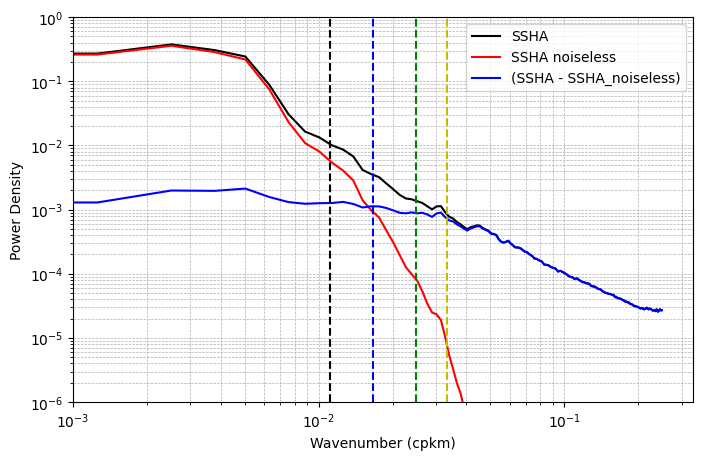

In [154]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(km, psd_ssha, '-k', label='SSHA')
plt.loglog(km, psd_ssha_noiseless, '-r', label='SSHA noiseless')
plt.loglog(km, psd_ssha_diff, '-b', label='(SSHA - SSHA_noiseless)')

plt.axvline(x=1/60, color='b', linestyle='--')

plt.axvline(x=1/40, color='g', linestyle='--')

plt.axvline(x=1/30, color='y', linestyle='--')

plt.axvline(x=1/90, color='k', linestyle='--')

# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-6, 1E0])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel("Power Density")
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

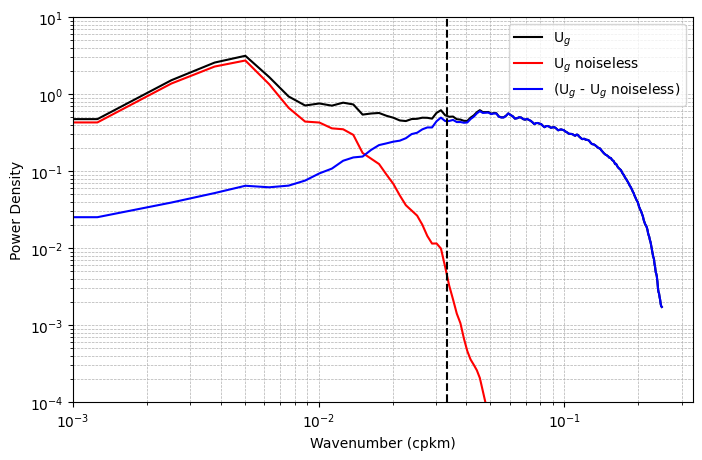

In [85]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(km, psd_ut, '-k', label='U${_g}$')
plt.loglog(km, psd_ut_noiseless, '-r', label='U${_g}$ noiseless')
plt.loglog(km, psd_ut_diff, '-b', label='(U${_g}$ - U${_g}$ noiseless)')

plt.axvline(x=1/30, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-4, 1E1])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel("Power Density")
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

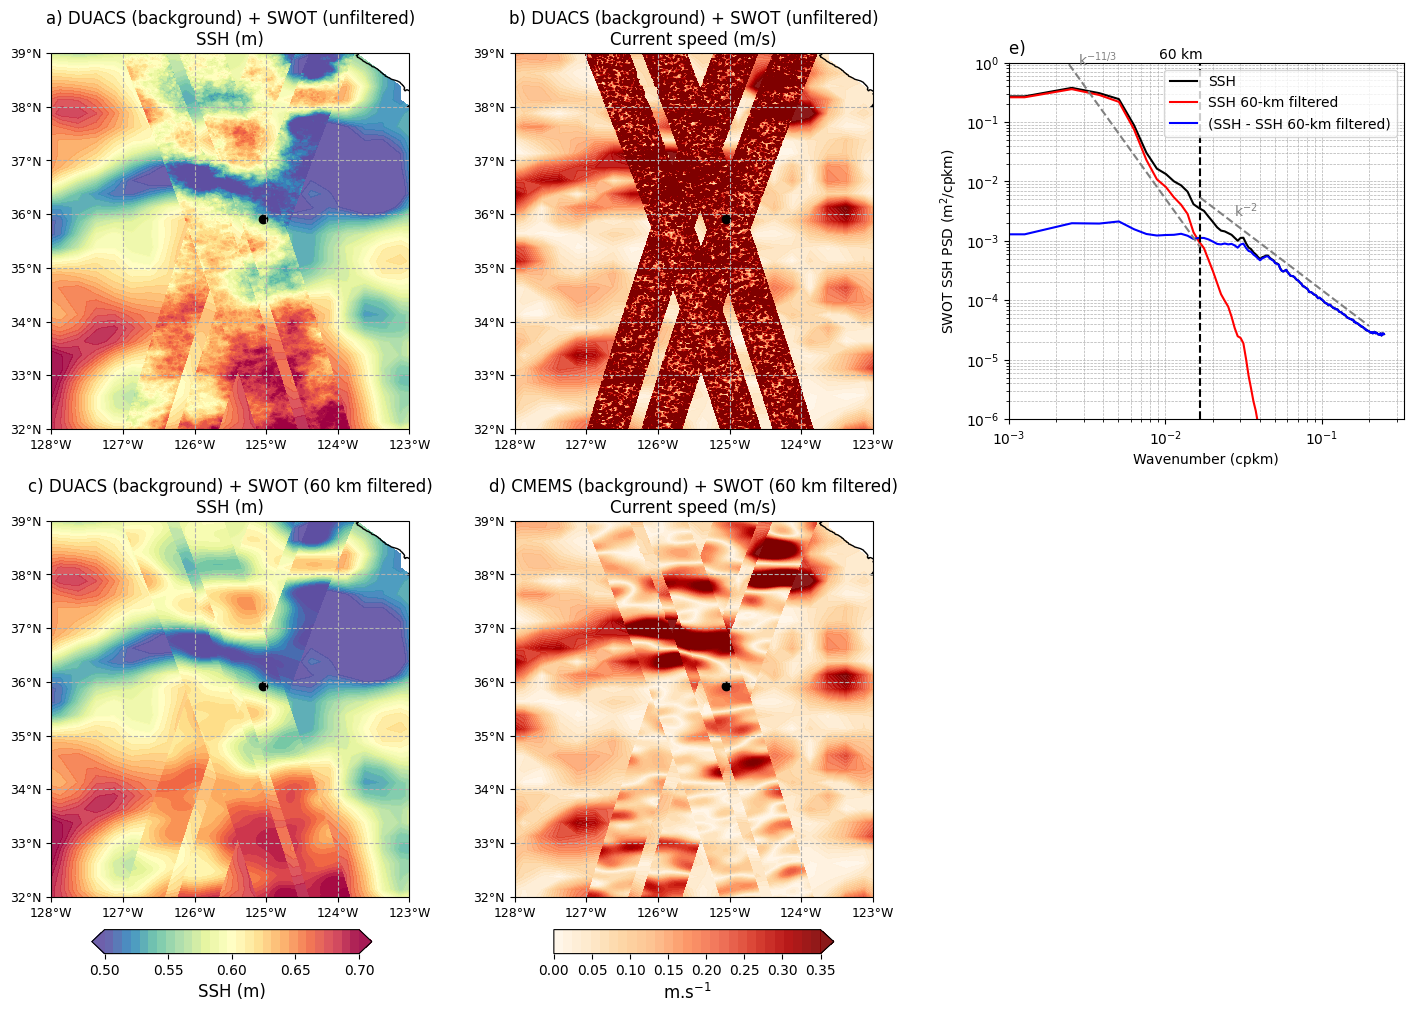

In [198]:
from cmocean import cm
# Define levels, colormap, and ticks for plotting
level = np.linspace(0.5, 0.7, 30)
level_u = np.linspace(0, .35, 30)
cmap_ssh = 'Spectral_r'
cmap_u = 'OrRd'#cm.thermal#'jet'
tick_ssh = [0.5,0.55,0.6,0.65,0.7]
tick_ut = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
cb_ut = 'm.s$^{-1}$'
label_fontsize = 12
tick_fontsize = 10
label_fontsize1 = 9 
proj = ccrs.PlateCarree()
rat = 0.75
def add_gridlines(ax, label_fontsize=12, x_ticks=None, y_ticks=None, x_labels=None, y_labels=None):
    gl = ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': label_fontsize}
    gl.ylabel_style = {'size': label_fontsize}
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    ax.set_extent([-128, -123, 32, 39], crs=ccrs.PlateCarree())
    # Set custom x-tick and y-tick locations and labels if provided
    if x_ticks is not None:
        ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    if y_ticks is not None:
        ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    if x_labels is not None:
        ax.set_xticklabels(x_labels, fontsize=label_fontsize)
    if y_labels is not None:
        ax.set_yticklabels(y_labels, fontsize=label_fontsize)
    
    return gl

# Custom x-tick and y-tick locations and labels
x_ticks = [-128, -127, -126, -125, -124, -123]
y_ticks = [32, 33, 34, 35, 36, 37, 38, 39]
x_labels = ['128°W', '127°W', '126°W', '125°W', '124°W', '123°W']
y_labels = ['32°N', '33°N', '34°N', '35°N', '36°N', '37°N', '38°N', '39°N']

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(14, 12), constrained_layout=True)
gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 1.1], height_ratios=[1., 1.,.75],  wspace=0.1, hspace=0.005)

# Create GeoAxes for the map plots with aspect ratio
ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax1.set_aspect(rat)
ax2 = fig.add_subplot(gs[0, 1], projection=proj)
ax2.set_aspect(rat)
ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax3.set_aspect(rat)
ax4 = fig.add_subplot(gs[1, 1], projection=proj)
ax4.set_aspect(rat)
ax5 = fig.add_subplot(gs[0, 2]) 
ax5.set_aspect(0.38)
# Re
# Plot DUACS SLA with SWOT overlay using contourf
c1 = ax1.contourf(lon, lat, duacs_sla, levels=level, cmap=cmap_ssh, alpha=0.9, extend='both', transform=ccrs.PlateCarree())
ax1.contourf(lon1, lat1, swot_sla, levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
ax1.contourf(lon2, lat2, swot_sla1, levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
ax1.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
ax1.set_title('a) DUACS (background) + SWOT (unfiltered)\nSSH (m)',fontsize = label_fontsize)
# ax1.set_xlim([-128, -123])
# ax1.set_ylim([32, 39])
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS)
add_gridlines(ax1, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

# Plot DUACS currents with SWOT overlay using contourf
c2 = ax2.contourf(lon, lat, duacs_currents, levels=level_u, cmap=cmap_u, alpha=.9, extend='both', transform=ccrs.PlateCarree())
ax2.contourf(lon1, lat1, swot_currents, levels=level_u, cmap=cmap_u, alpha=1, extend='both', transform=ccrs.PlateCarree())
ax2.contourf(lon2, lat2, swot_currents1, levels=level_u, cmap=cmap_u, alpha=1, extend='both', transform=ccrs.PlateCarree())
ax2.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
ax2.set_title('b) DUACS (background) + SWOT (unfiltered)\nCurrent speed (m/s)',fontsize=label_fontsize)
ax2.set_xlim([-128, -123])
ax2.set_ylim([32, 39])
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS)
add_gridlines(ax2, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

# Plotting the log-log plot
ax5.loglog(km, psd_ssha, '-k', label='SSH')
ax5.loglog(km, psd_ssha_noiseless, '-r',label='SSH 60-km filtered')
ax5.loglog(km, psd_ssha_diff, '-b', label='(SSH - SSH 60-km filtered)')
# ax5.axvline(x=1/70, color='k', linestyle='--')
# ax5.axvline(x=1/50, color='k', linestyle='--')
ax5.axvline(x=1/60, color='k', linestyle='--')
# plt.axvline(x=1/70, color='k', linestyle='--')

# Adding labels for each line
ax5.text(1/80, plt.ylim()[1] * 0.9, '60 km', color='k', ha='center')

# # Add K^-2 slope reference line
# k_ref = 1/100  # reference wavenumber (cpkm)
# psd_ref = 1e-3  # reference PSD value at k_ref (adjust based on your figure)

# # Generate line for slope -2
# k_slope = np.logspace(-3, -0.5, 100)
# psd_slope = psd_ref * (k_slope / k_ref) ** (-2)

# ax5.loglog(k_slope, psd_slope, '--', color='gray', label='k$^{-2}$')
# ax5.text(k_slope[10], psd_slope[10] * 1.2, 'k$^{-2}$', fontsize=10, color='gray')
# --- Add k^{-2} slope starting from 100 km wavelength ---
k_ref = 1/60  # reference wavenumber = 0.01 cpkm
psd_ref = psd_ssha[ np.argmin(np.abs(km - k_ref)) ] *1.5 # get PSD value at ~100 km

# Define range of wavenumbers to apply slope
k_slope = np.logspace(np.log10(k_ref), np.log10(1/5), 100)  # from 100 km to 20 km
psd_slope = psd_ref * (k_slope / k_ref)**(-2)

# Plot slope line
ax5.loglog(k_slope, psd_slope, '--', color='grey')

# Add label
ax5.text(k_slope[20], psd_slope[20]*1.3, 'k$^{-2}$', fontsize=10, color='grey')

k_ref_11_3 = 1/500  # start at 100 km
psd_ref_11_3 = psd_ssha[np.argmin(np.abs(km - k_ref_11_3))] * 5  # offset upward

# Wavenumber range for slope line
k_slope_11_3 = np.logspace(np.log10(k_ref_11_3), np.log10(1/60), 100)
psd_slope_11_3 = psd_ref_11_3 * (k_slope_11_3 / k_ref_11_3)**(-11/3)

# Plot slope
ax5.loglog(k_slope_11_3, psd_slope_11_3, '--', color='grey')

# Annotate the slope line
ax5.text(k_slope_11_3[15], psd_slope_11_3[15]*1.5, 'k$^{-11/3}$', fontsize=10, color='grey')


ax5.grid(True, which='both', linestyle='--', linewidth=0.5)
ax5.set_title('e) ',loc='left',fontsize=label_fontsize)
ax5.set_ylim([1E-6, 1E0])
ax5.set_xlim([1E-3, 1/3])
ax5.set_xlabel("Wavenumber (cpkm)")
ax5.set_ylabel("SWOT SSH PSD (m$^2$/cpkm)")
ax5.legend()
# ax5.loglog(km, psd_ssha_noiseless, '-r', label='SSHA noiseless')
# ax5.set_title('Power Spectral Density')
# ax5.set_xlabel("Wavenumber (cpkm)")
# ax5.set_ylabel("Power Density")
# ax5.legend()
# ax5.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot DUACS SLA with SWOT overlay using contourf (filtered)
c3 = ax3.contourf(lon, lat, duacs_sla, levels=level, cmap=cmap_ssh, alpha=.9, extend='both', transform=ccrs.PlateCarree())
ax3.contourf(lon1, lat1, swot_sla_filt, levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
ax3.contourf(lon2, lat2, swot_sla1_filt, levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
ax3.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
ax3.set_title('c) DUACS (background) + SWOT (60 km filtered)\nSSH (m)',fontsize=label_fontsize)
ax3.set_xlim([-128, -123])
ax3.set_ylim([32, 39])
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS)
add_gridlines(ax3, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)


# Plot DUACS currents with SWOT overlay using contourf (filtered)
c4 = ax4.contourf(lon, lat, duacs_currents, levels=level_u, cmap=cmap_u, alpha=.9, extend='max', transform=ccrs.PlateCarree())
ax4.contourf(lon1, lat1, swot_currents_filt, levels=level_u, cmap=cmap_u, alpha=1, extend='max', transform=ccrs.PlateCarree())
ax4.contourf(lon2, lat2, swot_currents1_filt, levels=level_u, cmap=cmap_u, alpha=1, extend='max', transform=ccrs.PlateCarree())
ax4.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
ax4.set_title('d) CMEMS (background) + SWOT (60 km filtered)\nCurrent speed (m/s)',fontsize=label_fontsize)
ax4.set_xlim([-128, -123])
ax4.set_ylim([32, 39])
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS)
add_gridlines(ax4, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

# ax4.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='--')

# Create colorbar axes
cbar_ax_ssh = fig.add_axes([0.06, 0.21, 0.2, 0.02])  # [left, bottom, width, height]
cbar_ax_total = fig.add_axes([0.39, 0.21, 0.2, 0.02])  # [left, bottom, width, height]

# Add colorbars
cbar_ssh = fig.colorbar(c3, cax=cbar_ax_ssh, orientation='horizontal', ticks=tick_ssh)
cbar_ssh.set_label('SSH (m)', fontsize=label_fontsize)
cbar_ssh.ax.tick_params(labelsize=tick_fontsize)

cbar_total = fig.colorbar(c4, cax=cbar_ax_total, orientation='horizontal', ticks=tick_ut, extend='max')
cbar_total.set_label(cb_ut, fontsize=label_fontsize)
cbar_total.ax.tick_params(labelsize=tick_fontsize)

plt.show()

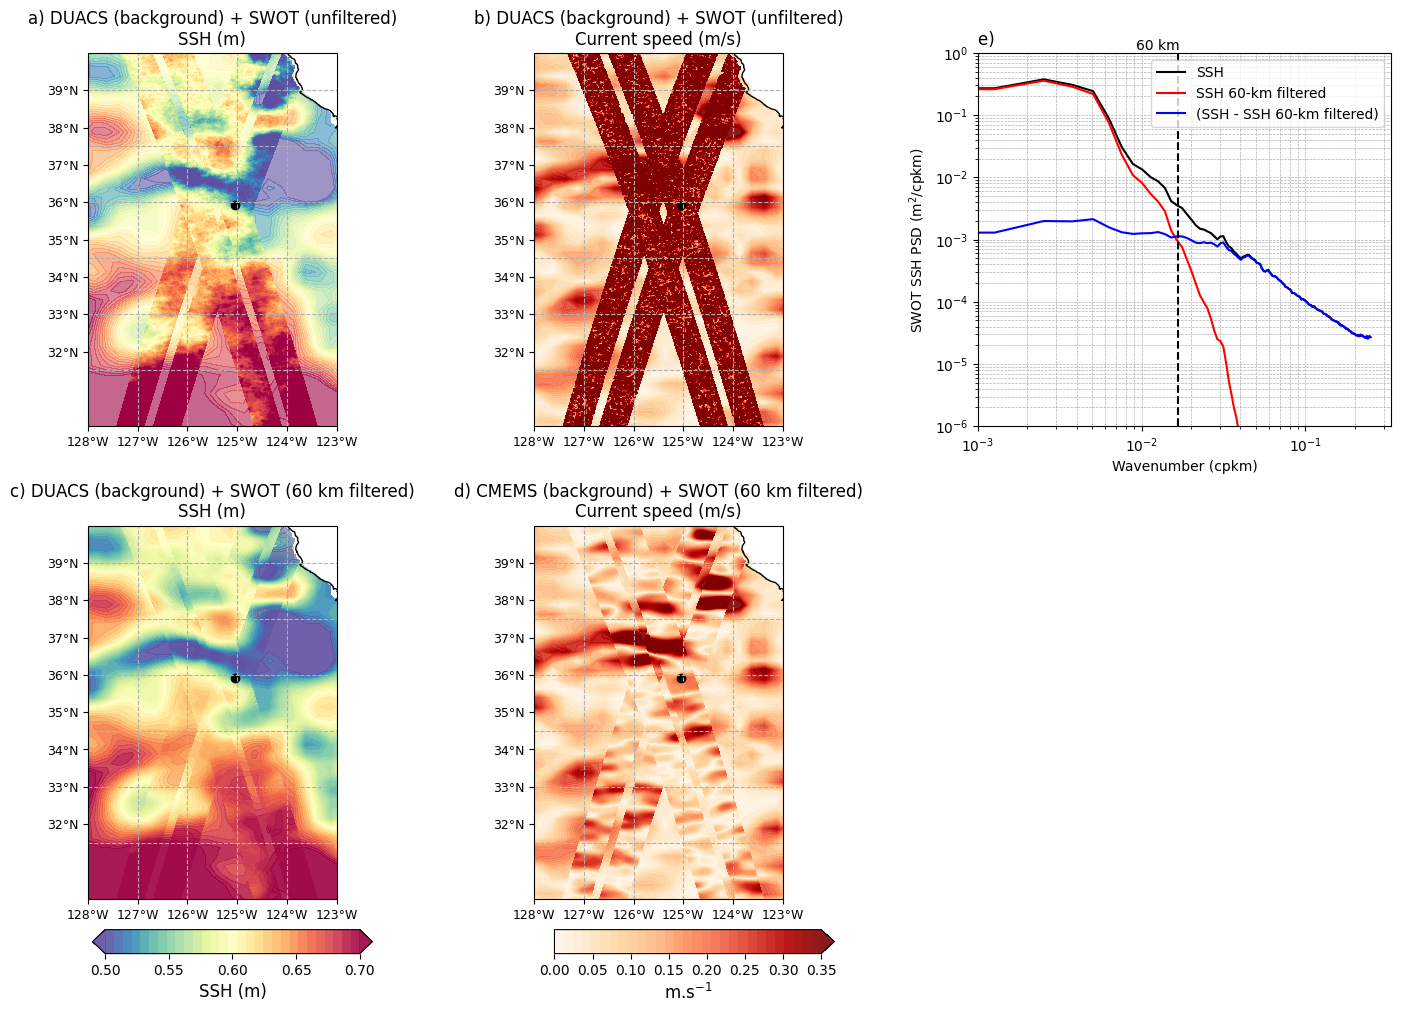

In [175]:
# from cmocean import cm
# # Define levels, colormap, and ticks for plotting
# level = np.linspace(0.5, 0.7, 30)
# level_u = np.linspace(0, .35, 30)
# cmap_ssh = 'Spectral_r'
# cmap_u = 'OrRd'#cm.thermal#'jet'
# tick_ssh = [0.5,0.55,0.6,0.65,0.7]
# tick_ut = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
# cb_ut = 'm.s$^{-1}$'
# label_fontsize = 12
# tick_fontsize = 10
# label_fontsize1 = 9 
# proj = ccrs.PlateCarree()
# rat = 0.75
# def add_gridlines(ax, label_fontsize=12, x_ticks=None, y_ticks=None, x_labels=None, y_labels=None):
#     gl = ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.xlabel_style = {'size': label_fontsize}
#     gl.ylabel_style = {'size': label_fontsize}
#     gl.xformatter = cticker.LongitudeFormatter()
#     gl.yformatter = cticker.LatitudeFormatter()
#     ax.set_extent([-128, -123, 30, 40], crs=ccrs.PlateCarree())
#     # Set custom x-tick and y-tick locations and labels if provided
#     if x_ticks is not None:
#         ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
#     if y_ticks is not None:
#         ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
#     if x_labels is not None:
#         ax.set_xticklabels(x_labels, fontsize=label_fontsize)
#     if y_labels is not None:
#         ax.set_yticklabels(y_labels, fontsize=label_fontsize)
    
#     return gl

# # Custom x-tick and y-tick locations and labels
# x_ticks = [-128, -127, -126, -125, -124, -123]
# y_ticks = [32, 33, 34, 35, 36, 37, 38, 39]
# x_labels = ['128°W', '127°W', '126°W', '125°W', '124°W', '123°W']
# y_labels = ['32°N', '33°N', '34°N', '35°N', '36°N', '37°N', '38°N', '39°N']

# # Create the figure and GridSpec layout
# fig = plt.figure(figsize=(14, 12), constrained_layout=True)
# gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 1.1], height_ratios=[1., 1.,.75],  wspace=0.1, hspace=0.005)

# # Create GeoAxes for the map plots with aspect ratio
# ax1 = fig.add_subplot(gs[0, 0], projection=proj)
# ax1.set_aspect(rat)
# ax2 = fig.add_subplot(gs[0, 1], projection=proj)
# ax2.set_aspect(rat)
# ax3 = fig.add_subplot(gs[1, 0], projection=proj)
# ax3.set_aspect(rat)
# ax4 = fig.add_subplot(gs[1, 1], projection=proj)
# ax4.set_aspect(rat)
# ax5 = fig.add_subplot(gs[0, 2]) 
# ax5.set_aspect(0.38)
# # Re
# # Plot DUACS SLA with SWOT overlay using contourf
# c1 = ax1.contourf(lon, lat, duacs_sla, levels=level, cmap=cmap_ssh, alpha=0.6, extend='both', transform=ccrs.PlateCarree())
# ax1.contourf(lon1, lat1, swot_sla, levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
# ax1.contourf(lon2, lat2, swot_sla1, levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
# ax1.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
# ax1.set_title('a) DUACS (background) + SWOT (unfiltered)\nSSH (m)',fontsize = label_fontsize)
# # ax1.set_xlim([-128, -123])
# # ax1.set_ylim([32, 39])
# ax1.coastlines()
# ax1.add_feature(cfeature.BORDERS)
# add_gridlines(ax1, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

# # Plot DUACS currents with SWOT overlay using contourf
# c2 = ax2.contourf(lon, lat, duacs_currents, levels=level_u, cmap=cmap_u, alpha=.9, extend='both', transform=ccrs.PlateCarree())
# ax2.contourf(lon1, lat1, swot_currents, levels=level_u, cmap=cmap_u, alpha=1, extend='both', transform=ccrs.PlateCarree())
# ax2.contourf(lon2, lat2, swot_currents1, levels=level_u, cmap=cmap_u, alpha=1, extend='both', transform=ccrs.PlateCarree())
# ax2.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
# ax2.set_title('b) DUACS (background) + SWOT (unfiltered)\nCurrent speed (m/s)',fontsize=label_fontsize)
# ax2.set_xlim([-128, -123])
# ax2.set_ylim([26, 39])
# ax2.coastlines()
# ax2.add_feature(cfeature.BORDERS)
# add_gridlines(ax2, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

# # Plotting the log-log plot
# ax5.loglog(km, psd_ssha, '-k', label='SSH')
# ax5.loglog(km, psd_ssha_noiseless, '-r',label='SSH 60-km filtered')
# ax5.loglog(km, psd_ssha_diff, '-b', label='(SSH - SSH 60-km filtered)')
# # ax5.axvline(x=1/70, color='k', linestyle='--')
# # ax5.axvline(x=1/50, color='k', linestyle='--')
# ax5.axvline(x=1/60, color='k', linestyle='--')
# # plt.axvline(x=1/70, color='k', linestyle='--')

# # Adding labels for each line
# ax5.text(1/80, plt.ylim()[1] * 0.9, '60 km', color='k', ha='center')


# ax5.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax5.set_title('e) ',loc='left',fontsize=label_fontsize)
# ax5.set_ylim([1E-6, 1E0])
# ax5.set_xlim([1E-3, 1/3])
# ax5.set_xlabel("Wavenumber (cpkm)")
# ax5.set_ylabel("SWOT SSH PSD (m$^2$/cpkm)")
# ax5.legend()
# # ax5.loglog(km, psd_ssha_noiseless, '-r', label='SSHA noiseless')
# # ax5.set_title('Power Spectral Density')
# # ax5.set_xlabel("Wavenumber (cpkm)")
# # ax5.set_ylabel("Power Density")
# # ax5.legend()
# # ax5.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Plot DUACS SLA with SWOT overlay using contourf (filtered)
# c3 = ax3.contourf(lon, lat, duacs_sla, levels=level, cmap=cmap_ssh, alpha=.9, extend='both', transform=ccrs.PlateCarree())
# ax3.contourf(lon1, lat1, swot_sla_filt, levels=level, cmap=cmap_ssh, alpha=.6, extend='both', transform=ccrs.PlateCarree())
# ax3.contourf(lon2, lat2, swot_sla1_filt, levels=level, cmap=cmap_ssh, alpha=.6, extend='both', transform=ccrs.PlateCarree())
# ax3.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
# ax3.set_title('c) DUACS (background) + SWOT (60 km filtered)\nSSH (m)',fontsize=label_fontsize)
# ax3.set_xlim([-128, -123])
# ax3.set_ylim([30, 39])
# ax3.coastlines()
# ax3.add_feature(cfeature.BORDERS)
# add_gridlines(ax3, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)


# # Plot DUACS currents with SWOT overlay using contourf (filtered)
# c4 = ax4.contourf(lon, lat, duacs_currents, levels=level_u, cmap=cmap_u, alpha=.9, extend='max', transform=ccrs.PlateCarree())
# ax4.contourf(lon1, lat1, swot_currents_filt, levels=level_u, cmap=cmap_u, alpha=1, extend='max', transform=ccrs.PlateCarree())
# ax4.contourf(lon2, lat2, swot_currents1_filt, levels=level_u, cmap=cmap_u, alpha=1, extend='max', transform=ccrs.PlateCarree())
# ax4.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
# ax4.set_title('d) CMEMS (background) + SWOT (60 km filtered)\nCurrent speed (m/s)',fontsize=label_fontsize)
# ax4.set_xlim([-128, -123])
# ax4.set_ylim([30, 39])
# ax4.coastlines()
# ax4.add_feature(cfeature.BORDERS)
# add_gridlines(ax4, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

# # ax4.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='--')

# # Create colorbar axes
# cbar_ax_ssh = fig.add_axes([0.06, 0.21, 0.2, 0.02])  # [left, bottom, width, height]
# cbar_ax_total = fig.add_axes([0.39, 0.21, 0.2, 0.02])  # [left, bottom, width, height]

# # Add colorbars
# cbar_ssh = fig.colorbar(c3, cax=cbar_ax_ssh, orientation='horizontal', ticks=tick_ssh)
# cbar_ssh.set_label('SSH (m)', fontsize=label_fontsize)
# cbar_ssh.ax.tick_params(labelsize=tick_fontsize)

# cbar_total = fig.colorbar(c4, cax=cbar_ax_total, orientation='horizontal', ticks=tick_ut, extend='max')
# cbar_total.set_label(cb_ut, fontsize=label_fontsize)
# cbar_total.ax.tick_params(labelsize=tick_fontsize)

# plt.show()

In [76]:
nc_avi.time[55].values

numpy.datetime64('2023-05-23T00:00:00.000000000')

In [ ]:
# lon, lat = np.meshgrid(lon, lat)
duacs_sla = nc_avi.sla.values
swot_sla = nc_swot_13_filt.SSHA.values  # Highlighted region for SWOT
swot_sla1 = nc_swot_26_filt.SSHA.values  # Highlighted region for SWOT

swot_sla_filt = nc_swot_13_filt.SSHA_noiseless.values  # Highlighted region for SWOT
swot_sla1_filt = nc_swot_26_filt.SSHA_noiseless.values  # Highlighted region for SWOT

duacs_currents = np.sqrt(nc_avi.ugosa.values**2+nc_avi.ugosa.values**2)
swot_currents = np.sqrt(nc_swot_13_filt.u_g.values**2+nc_swot_13_filt.u_g.values**2)  # Highlighted region for SWOT
swot_currents1 = np.sqrt(nc_swot_26_filt.u_g.values**2+nc_swot_26_filt.u_g.values**2)  # Highlighted region for SWOT

duacs_currents = np.sqrt(nc_avi.ugosa.values**2+nc_avi.ugosa.values**2)
swot_currents = np.sqrt(nc_swot_13_filt.u_g.values**2+nc_swot_13_filt.u_g.values**2)  # Highlighted region for SWOT
swot_currents1 = np.sqrt(nc_swot_26_filt.u_g.values**2+nc_swot_26_filt.u_g.values**2)  # Highlighted region for SWOT

swot_currents_filt = np.sqrt(nc_swot_13_filt.u_g_noiseless.values**2+nc_swot_13_filt.u_g_noiseless.values**2)  # Highlighted region for SWOT
swot_currents1_filt = np.sqrt(nc_swot_26_filt.u_g_noiseless.values**2+nc_swot_26_filt.u_g_noiseless.values**2)  # Highlighted region for SWOT




from cmocean import cm
# Define levels, colormap, and ticks for plotting
level = np.linspace(-0.15, 0.15, 30)
level_u = np.linspace(0, .35, 30)
cmap_ssh = plt.cm.RdBu_r
cmap_u = 'jet'#cm.thermal#'jet'
tick_ssh = [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15]
tick_ut = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
cb_ut = 'm.s$^{-1}$'
label_fontsize = 12
tick_fontsize = 10
label_fontsize1 = 9 
proj = ccrs.PlateCarree()
rat = 0.75
def add_gridlines(ax, label_fontsize=12, x_ticks=None, y_ticks=None, x_labels=None, y_labels=None):
    gl = ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': label_fontsize}
    gl.ylabel_style = {'size': label_fontsize}
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    ax.set_extent([-128, -123, 32, 39], crs=ccrs.PlateCarree())
    # Set custom x-tick and y-tick locations and labels if provided
    if x_ticks is not None:
        ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    if y_ticks is not None:
        ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    if x_labels is not None:
        ax.set_xticklabels(x_labels, fontsize=label_fontsize)
    if y_labels is not None:
        ax.set_yticklabels(y_labels, fontsize=label_fontsize)
    
    return gl

# Custom x-tick and y-tick locations and labels
x_ticks = [-128, -127, -126, -125, -124, -123]
y_ticks = [32, 33, 34, 35, 36, 37, 38, 39]
x_labels = ['128°W', '127°W', '126°W', '125°W', '124°W', '123°W']
y_labels = ['32°N', '33°N', '34°N', '35°N', '36°N', '37°N', '38°N', '39°N']
for i in range(0,80):
    # Create the figure and GridSpec layout
    fig = plt.figure(figsize=(14, 12), constrained_layout=True)
    gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 1.1], height_ratios=[1., 1.,.75],  wspace=0.1, hspace=0.005)

    # Create GeoAxes for the map plots with aspect ratio
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    ax1.set_aspect(rat)
    ax2 = fig.add_subplot(gs[0, 1], projection=proj)
    ax2.set_aspect(rat)
    ax3 = fig.add_subplot(gs[1, 0], projection=proj)
    ax3.set_aspect(rat)
    ax4 = fig.add_subplot(gs[1, 1], projection=proj)
    ax4.set_aspect(rat)
    ax5 = fig.add_subplot(gs[0, 2]) 
    ax5.set_aspect(0.38)
    # Re
    # Plot DUACS SLA with SWOT overlay using contourf
    c1 = ax1.contourf(lon, lat, duacs_sla[i], levels=level, cmap=cmap_ssh, alpha=0.6, extend='both', transform=ccrs.PlateCarree())
    ax1.contourf(lon1, lat1, swot_sla[i], levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax1.contourf(lon2, lat2, swot_sla1[i], levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax1.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax1.set_title(f'a) DUACS (background) + SWOT (unfiltered)\nSSHA (m) time,{nc_avi.time[i].values}',fontsize = label_fontsize)
    # ax1.set_xlim([-128, -123])
    # ax1.set_ylim([32, 39])
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS)
    add_gridlines(ax1, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

    # Plot DUACS currents with SWOT overlay using contourf
    c2 = ax2.contourf(lon, lat, duacs_currents[i], levels=level_u, cmap=cmap_u, alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax2.contourf(lon1, lat1, swot_currents[i], levels=level_u, cmap=cmap_u, alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax2.contourf(lon2, lat2, swot_currents1[i], levels=level_u, cmap=cmap_u, alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax2.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax2.set_title(f'b) DUACS (background) + SWOT (unfiltered)\nCurrent speed (m/s) time,{nc_swot_13_filt.timec[i].values}',fontsize=label_fontsize)
    ax2.set_xlim([-128, -123])
    ax2.set_ylim([32, 39])
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS)
    add_gridlines(ax2, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

    # # Plotting the log-log plot
    # ax5.loglog(km, psd_ssha, '-k', label='SSHA')
    # ax5.loglog(km, psd_ssha_noiseless, '-r',label='SSHA 60-km filtered')
    # ax5.loglog(km, psd_ssha_diff, '-b', label='(SSHA - SSHA 60-km filtered)')
    # # ax5.axvline(x=1/70, color='k', linestyle='--')
    # # ax5.axvline(x=1/50, color='k', linestyle='--')
    # ax5.axvline(x=1/60, color='k', linestyle='--')
    # # plt.axvline(x=1/70, color='k', linestyle='--')

    # # Adding labels for each line
    # ax5.text(1/80, plt.ylim()[1] * 0.9, '60 km', color='k', ha='center')


    # ax5.grid(True, which='both', linestyle='--', linewidth=0.5)
    # ax5.set_title('e) ',loc='left',fontsize=label_fontsize)
    # ax5.set_ylim([1E-6, 1E0])
    # ax5.set_xlim([1E-3, 1/3])
    # ax5.set_xlabel("Wavenumber (cpkm)")
    # ax5.set_ylabel("SWOT SSHA PSD (m$^2$/cpkm)")
    # ax5.legend()
    # # ax5.loglog(km, psd_ssha_noiseless, '-r', label='SSHA noiseless')
    # # ax5.set_title('Power Spectral Density')
    # # ax5.set_xlabel("Wavenumber (cpkm)")
    # # ax5.set_ylabel("Power Density")
    # # ax5.legend()
    # # ax5.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot DUACS SLA with SWOT overlay using contourf (filtered)
    c3 = ax3.contourf(lon, lat, duacs_sla[i], levels=level, cmap=cmap_ssh, alpha=.6, extend='both', transform=ccrs.PlateCarree())
    ax3.contourf(lon1, lat1, swot_sla_filt[i], levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax3.contourf(lon2, lat2, swot_sla1_filt[i], levels=level, cmap=cmap_ssh, alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax3.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax3.set_title(f'c) DUACS (background) + SWOT (60 km filtered)\nSSHA (m)  time,{nc_swot_26_filt.timec[i].values}',fontsize=label_fontsize)
    ax3.set_xlim([-128, -123])
    ax3.set_ylim([32, 39])
    ax3.coastlines()
    ax3.add_feature(cfeature.BORDERS)
    add_gridlines(ax3, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)


    # Plot DUACS currents with SWOT overlay using contourf (filtered)
    c4 = ax4.contourf(lon, lat, duacs_currents[i], levels=level_u, cmap=cmap_u, alpha=1, extend='max', transform=ccrs.PlateCarree())
    ax4.contourf(lon1, lat1, swot_currents_filt[i], levels=level_u, cmap=cmap_u, alpha=1, extend='max', transform=ccrs.PlateCarree())
    ax4.contourf(lon2, lat2, swot_currents1_filt[i], levels=level_u, cmap=cmap_u, alpha=1, extend='max', transform=ccrs.PlateCarree())
    ax4.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax4.set_title('d) CMEMS (background) + SWOT (60 km filtered)\nCurrent speed (m/s)',fontsize=label_fontsize)
    ax4.set_xlim([-128, -123])
    ax4.set_ylim([32, 39])
    ax4.coastlines()
    ax4.add_feature(cfeature.BORDERS)
    add_gridlines(ax4, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks, x_labels=x_labels, y_labels=y_labels)

    # ax4.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='--')

    # Create colorbar axes
    cbar_ax_ssh = fig.add_axes([0.06, 0.21, 0.2, 0.02])  # [left, bottom, width, height]
    cbar_ax_total = fig.add_axes([0.39, 0.21, 0.2, 0.02])  # [left, bottom, width, height]

    # Add colorbars
    cbar_ssh = fig.colorbar(c3, cax=cbar_ax_ssh, orientation='horizontal', ticks=tick_ssh)
    cbar_ssh.set_label('SSHA (m)', fontsize=label_fontsize)
    cbar_ssh.ax.tick_params(labelsize=tick_fontsize)

    cbar_total = fig.colorbar(c4, cax=cbar_ax_total, orientation='horizontal', ticks=tick_ut, extend='max')
    cbar_total.set_label(cb_ut, fontsize=label_fontsize)
    cbar_total.ax.tick_params(labelsize=tick_fontsize)

    plt.show()

In [121]:
nc_sst = xr.open_dataset('METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_1743420265017.nc')

In [122]:
nc_sst

<xarray.Dataset> Size: 722kB
Dimensions:       (time: 3, latitude: 200, longitude: 300)
Coordinates:
  * time          (time) datetime64[ns] 24B 2023-05-29 2023-05-30 2023-05-31
  * latitude      (latitude) float32 800B 30.02 30.07 30.12 ... 39.92 39.97
  * longitude     (longitude) float32 1kB -130.0 -129.9 -129.9 ... -115.1 -115.0
Data variables:
    analysed_sst  (time, latitude, longitude) float32 720kB ...
Attributes:
    Conventions:       CF-1.11
    title:             Global SST & Sea Ice Analysis, L4 OSTIA, 0.05 deg dail...
    institution:       UKMO
    source:            AVHRR18_G-NAVO-L2P-V1.0, AVHRR19_G-NAVO-L2P-V1.0, AVHR...
    history:           Created from sst.nc; obs_anal.nc; seaice.nc
    references:        Good S, Fiedler E, Mao C, Martin MJ, Maycock A, Reid R...
    comment:           WARNING Some applications are unable to properly handl...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001
    subset:datasetId:  METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2
    subset:date:       2025-03-31T11:24:25.017Z

In [126]:
from cmocean import cm 

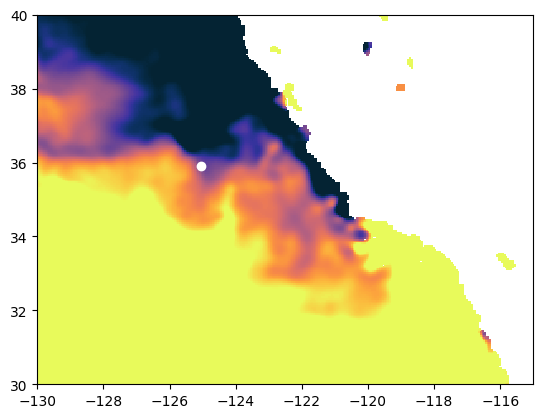

In [137]:
plt.pcolor(nc_sst.longitude,nc_sst.latitude, nc_sst.analysed_sst[0] - 273.15, vmin = 13, vmax = 15, cmap = cm.thermal)
plt. scatter(lon_p, lat_p, color='w')


In [105]:
nc_sst.analysed_sst[0].values

array([[292.09, 292.11, 292.13, ...,    nan,    nan,    nan],
       [292.08, 292.11, 292.12, ...,    nan,    nan,    nan],
       [292.07, 292.09, 292.11, ...,    nan,    nan,    nan],
       ...,
       [286.3 , 286.29, 286.28, ...,    nan,    nan,    nan],
       [286.29, 286.28, 286.27, ...,    nan,    nan,    nan],
       [286.29, 286.28, 286.27, ...,    nan,    nan,    nan]],
      dtype=float32)

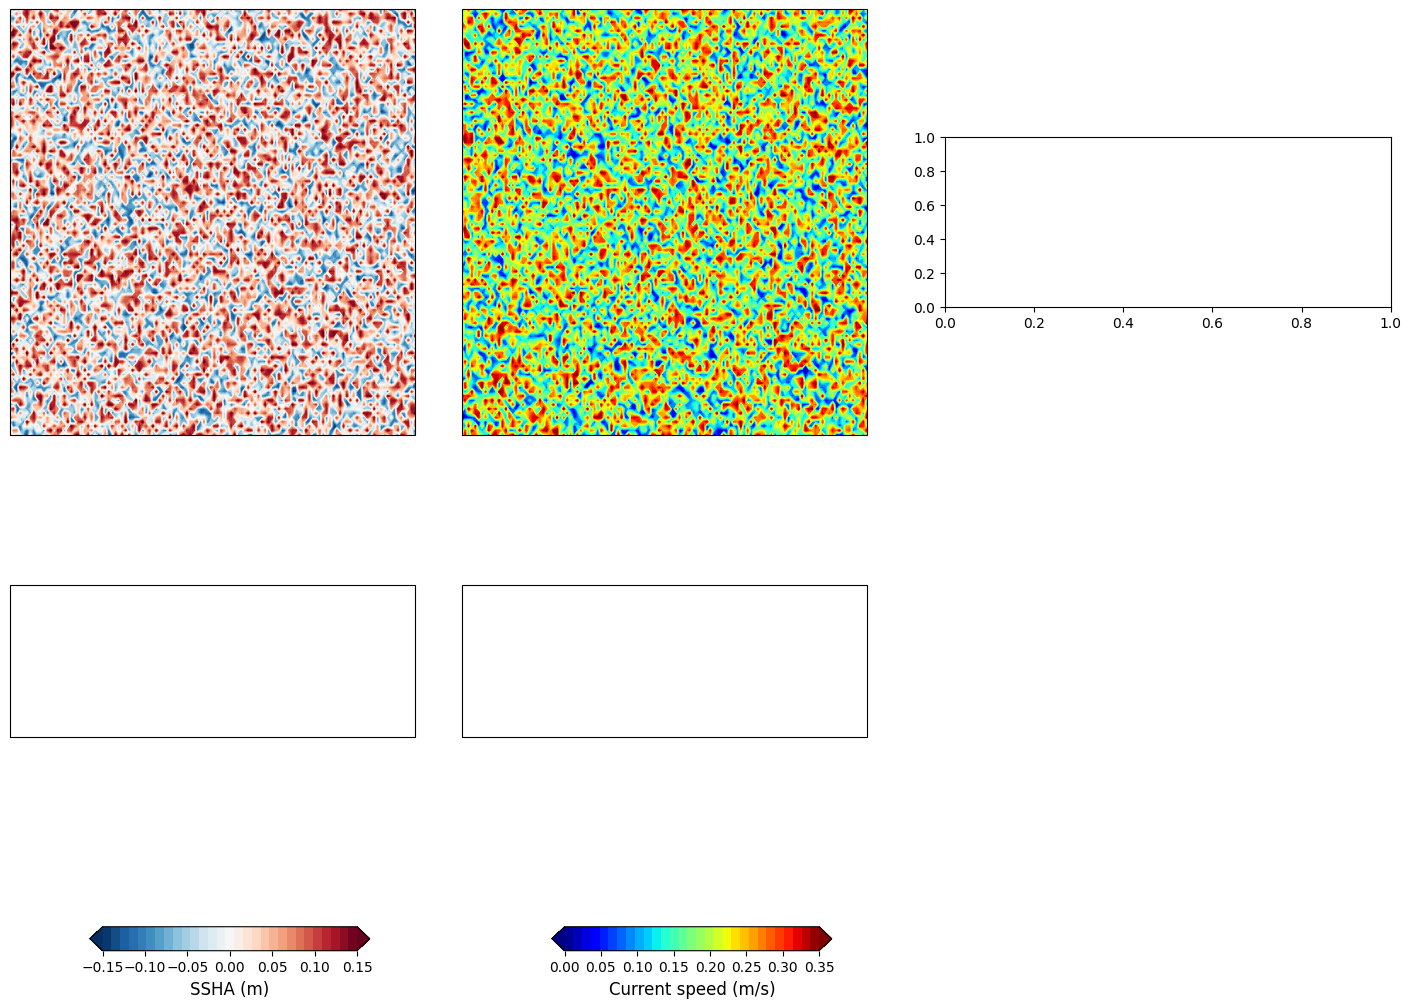

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# --- Example data setup ---
# Assume that these arrays have a time dimension as their first axis.
# For demonstration, here we create dummy arrays.
ntime = 20  # total number of time steps
ny, nx = 100, 120  # spatial dimensions
lon = np.linspace(-128, -123, nx)
lat = np.linspace(32, 39, ny)
lon, lat = np.meshgrid(lon, lat)

# Dummy 3D data: shape (ntime, ny, nx)
duacs_sla = np.random.uniform(-0.15, 0.15, size=(ntime, ny, nx))
swot_sla = np.random.uniform(-0.15, 0.15, size=(ntime, ny, nx))
swot_sla1 = np.random.uniform(-0.15, 0.15, size=(ntime, ny, nx))
swot_sla_filt = np.random.uniform(-0.15, 0.15, size=(ntime, ny, nx))
swot_sla1_filt = np.random.uniform(-0.15, 0.15, size=(ntime, ny, nx))

# For currents we also assume 3D arrays. (Here we simply use random data.)
duacs_currents = np.random.uniform(0, 0.35, size=(ntime, ny, nx))
swot_currents = np.random.uniform(0, 0.35, size=(ntime, ny, nx))
swot_currents1 = np.random.uniform(0, 0.35, size=(ntime, ny, nx))
swot_currents_filt = np.random.uniform(0, 0.35, size=(ntime, ny, nx))
swot_currents1_filt = np.random.uniform(0, 0.35, size=(ntime, ny, nx))

# Dummy coordinates for SWOT regions and a point (adjust as needed)
lon1, lat1 = lon, lat   # e.g., SWOT region 1 (unfiltered)
lon2, lat2 = lon, lat   # e.g., SWOT region 2 (unfiltered)
lon_p, lat_p = -125.5, 35.5  # a point of interest

# --- Plot settings ---
level = np.linspace(-0.15, 0.15, 30)
level_u = np.linspace(0, 0.35, 30)
cmap_ssh = plt.cm.RdBu_r
cmap_u = 'jet'
tick_ssh = [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15]
tick_ut = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
label_fontsize = 12
tick_fontsize = 10
label_fontsize1 = 9
proj = ccrs.PlateCarree()
rat = 0.75

# A helper function to add gridlines and extent to an axes
def add_gridlines(ax, label_fontsize=12, x_ticks=None, y_ticks=None, x_labels=None, y_labels=None):
    gl = ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': label_fontsize}
    gl.ylabel_style = {'size': label_fontsize}
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    ax.set_extent([-128, -123, 32, 39], crs=ccrs.PlateCarree())
    if x_ticks is not None:
        ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    if y_ticks is not None:
        ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    if x_labels is not None:
        ax.set_xticklabels(x_labels, fontsize=label_fontsize)
    if y_labels is not None:
        ax.set_yticklabels(y_labels, fontsize=label_fontsize)
    return gl

x_ticks = [-128, -127, -126, -125, -124, -123]
y_ticks = [32, 33, 34, 35, 36, 37, 38, 39]
x_labels = ['128°W', '127°W', '126°W', '125°W', '124°W', '123°W']
y_labels = ['32°N', '33°N', '34°N', '35°N', '36°N', '37°N', '38°N', '39°N']

# --- Create the figure and subplots ---
fig = plt.figure(figsize=(14, 12), constrained_layout=True)
gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 1.1], height_ratios=[1., 1., 0.75],  wspace=0.1, hspace=0.005)

# Create map axes with projections for the SSH and currents
ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax1.set_aspect(rat)
ax2 = fig.add_subplot(gs[0, 1], projection=proj)
ax2.set_aspect(rat)
ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax3.set_aspect(rat)
ax4 = fig.add_subplot(gs[1, 1], projection=proj)
ax4.set_aspect(rat)
# For the extra plot (e.g., spectral plot) we leave it here if needed.
ax5 = fig.add_subplot(gs[0, 2])
ax5.set_aspect(0.38)

# (Optional) Create static colorbar axes if you want them outside the animation loop.
cbar_ax_ssh = fig.add_axes([0.06, 0.21, 0.2, 0.02])
cbar_ax_total = fig.add_axes([0.39, 0.21, 0.2, 0.02])

# We initialize the colorbars with dummy mappables (they will be updated along with the plots).
dummy_contour = ax1.contourf(lon, lat, duacs_sla[0,:,:], levels=level, cmap=cmap_ssh, extend='both', transform=ccrs.PlateCarree())
cbar_ssh = fig.colorbar(dummy_contour, cax=cbar_ax_ssh, orientation='horizontal', ticks=tick_ssh)
cbar_ssh.set_label('SSHA (m)', fontsize=label_fontsize)
cbar_ssh.ax.tick_params(labelsize=tick_fontsize)

dummy_contour2 = ax2.contourf(lon, lat, duacs_currents[0,:,:], levels=level_u, cmap=cmap_u, extend='both', transform=ccrs.PlateCarree())
cbar_total = fig.colorbar(dummy_contour2, cax=cbar_ax_total, orientation='horizontal', ticks=tick_ut, extend='max')
cbar_total.set_label('Current speed (m/s)', fontsize=label_fontsize)
cbar_total.ax.tick_params(labelsize=tick_fontsize)

# --- Animation update function ---
def update(frame):
    # Clear only the map axes (not the colorbar axes)
    for ax in [ax1, ax2, ax3, ax4]:
        ax.clear()
    
    # --- Panel a): DUACS SLA (background) + SWOT (unfiltered) ---
    ax1.contourf(lon, lat, duacs_sla[frame,:,:], levels=level, cmap=cmap_ssh,
                 alpha=0.6, extend='both', transform=ccrs.PlateCarree())
    ax1.contourf(lon, lat, swot_sla[frame,:,:], levels=level, cmap=cmap_ssh,
                 alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax1.contourf(lon, lat, swot_sla1[frame,:,:], levels=level, cmap=cmap_ssh,
                 alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax1.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax1.set_title(f'a) DUACS + SWOT (unfiltered)\nSSHA (m)  t={frame}', fontsize=label_fontsize)
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS)
    add_gridlines(ax1, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks,
                  x_labels=x_labels, y_labels=y_labels)
    
    # --- Panel b): DUACS currents (background) + SWOT currents (unfiltered) ---
    ax2.contourf(lon, lat, duacs_currents[frame,:,:], levels=level_u, cmap=cmap_u,
                 alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax2.contourf(lon, lat, swot_currents[frame,:,:], levels=level_u, cmap=cmap_u,
                 alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax2.contourf(lon, lat, swot_currents1[frame,:,:], levels=level_u, cmap=cmap_u,
                 alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax2.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax2.set_title(f'b) DUACS + SWOT (unfiltered)\nCurrent speed (m/s)  t={frame}', fontsize=label_fontsize)
    ax2.set_xlim([-128, -123])
    ax2.set_ylim([32, 39])
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS)
    add_gridlines(ax2, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks,
                  x_labels=x_labels, y_labels=y_labels)
    
    # --- Panel c): DUACS SLA (background) + SWOT (60 km filtered) ---
    ax3.contourf(lon, lat, duacs_sla[frame,:,:], levels=level, cmap=cmap_ssh,
                 alpha=0.6, extend='both', transform=ccrs.PlateCarree())
    ax3.contourf(lon, lat, swot_sla_filt[frame,:,:], levels=level, cmap=cmap_ssh,
                 alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax3.contourf(lon, lat, swot_sla1_filt[frame,:,:], levels=level, cmap=cmap_ssh,
                 alpha=1, extend='both', transform=ccrs.PlateCarree())
    ax3.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax3.set_title(f'c) DUACS + SWOT (60 km filtered)\nSSHA (m)  t={frame}', fontsize=label_fontsize)
    ax3.set_xlim([-128, -123])
    ax3.set_ylim([32, 39])
    ax3.coastlines()
    ax3.add_feature(cfeature.BORDERS)
    add_gridlines(ax3, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks,
                  x_labels=x_labels, y_labels=y_labels)
    
    # --- Panel d): DUACS currents (background) + SWOT currents (60 km filtered) ---
    ax4.contourf(lon, lat, duacs_currents[frame,:,:], levels=level_u, cmap=cmap_u,
                 alpha=1, extend='max', transform=ccrs.PlateCarree())
    ax4.contourf(lon, lat, swot_currents_filt[frame,:,:], levels=level_u, cmap=cmap_u,
                 alpha=1, extend='max', transform=ccrs.PlateCarree())
    ax4.contourf(lon, lat, swot_currents1_filt[frame,:,:], levels=level_u, cmap=cmap_u,
                 alpha=1, extend='max', transform=ccrs.PlateCarree())
    ax4.scatter(lon_p, lat_p, color='k', transform=ccrs.PlateCarree())
    ax4.set_title(f'd) DUACS + SWOT (60 km filtered)\nCurrent speed (m/s)  t={frame}', fontsize=label_fontsize)
    ax4.set_xlim([-128, -123])
    ax4.set_ylim([32, 39])
    ax4.coastlines()
    ax4.add_feature(cfeature.BORDERS)
    add_gridlines(ax4, label_fontsize=label_fontsize1, x_ticks=x_ticks, y_ticks=y_ticks,
                  x_labels=x_labels, y_labels=y_labels)
    
    # (Optionally, update other panels (e.g., ax5) if needed.)
    return []  # Returning an empty list since blit=False

# --- Create the animation ---
# anim = animation.FuncAnimation(fig, update, frames=ntime, interval=500, blit=False)

plt.show()


In [143]:
from scipy import signal, stats
import numpy as np
from scipy.fft import fft, ifft, fftfreq

def lonlat2km(lon_orig, lat_orig, lon, lat):
    con = np.radians(lat_orig)
    ymetr = 111132.92 - 559.82 * np.cos(2 * con) + 1.175 * np.cos(4 * con) - 0.0023 * np.cos(6 * con)
    xmetr = 111412.84 * np.cos(con) - 93.50 * np.cos(3 * con) + 0.0118 * np.cos(5 * con)
    east = (lon - lon_orig) * xmetr / 1000
    north = (lat - lat_orig) * ymetr / 1000
    return east, north

def filter_spectrum_above_50km(freq, PI, k_cutoff=1/50):
    """
    Zero out frequencies corresponding to scales smaller than 50 km (i.e., wavenumbers higher than 1/50 km).

    Parameters:
    - freq (array): Frequencies corresponding to the power spectrum.
    - PI (array): Power spectrum array.
    - k_cutoff (float): Wavenumber cutoff in cycles/km (default corresponds to 50 km).
    
    Returns:
    - Filtered PI with high wavenumbers removed.
    """
    # Apply filter: keep only scales larger than 50 km (low-pass filter)
    filtered_PI = PI.copy()
    filtered_PI[freq > k_cutoff] = 0  # Zero out the components corresponding to high frequencies (small scales)
    return filtered_PI

def reconstruct_from_filtered_spectrum(freq, tns, dx, k_cutoff=1/50):
    """
    Reconstruct data in the spatial domain after filtering out high frequencies corresponding to scales < 50 km.

    Parameters:
    - freq: Frequency array from the Fourier transform.
    - tns: The original transect (data).
    - dx: The spatial resolution (distance between points).
    - k_cutoff: Wavenumber corresponding to 50 km scale (default = 1/50 km).
    
    Returns:
    - Reconstructed data in the spatial domain without scales < 50 km.
    """
    # Compute FFT of the data
    tns_fft = fft(tns)
    
    # Compute the corresponding wavenumbers
    N = len(tns)
    freqs = fftfreq(N, d=dx)
    
    # Zero out frequencies above the cutoff (scales < 50 km)
    tns_fft[np.abs(freqs) > k_cutoff] = 0
    
    # Perform inverse FFT to get the filtered data back in the spatial domain
    tns_filtered = np.real(ifft(tns_fft))
    
    return tns_filtered

def compute_spectrum_and_filter(data, data_obs, lon, lat, tracks, lnk=199, k_cutoff=1/50):
    """
    Compute the power spectrum for the given data, filter out scales smaller than 50 km, and return the filtered data.
    
    Parameters:
    data (numpy.ndarray): The primary data array (time, lines, pixels).
    data_obs (numpy.ndarray): The observed data array (time, lines, pixels).
    lon (numpy.ndarray): Longitude values corresponding to the data.
    lat (numpy.ndarray): Latitude values corresponding to the data.
    tracks (numpy.ndarray): Array of track indices to process.
    lnk (int): Length of k (default is 199).
    k_cutoff (float): Wavenumber cutoff for 50 km scale (default = 1/50 km).
    
    Returns:
    dict: A dictionary containing the filtered power spectra, frequencies, and filtered spatial data.
    """
    ind_time = data.shape[0]  # Number of time indices
    data_filtered = np.full_like(data, np.nan)  # To store the filtered spatial data
    data_diff = data_obs - data

    # Initialize arrays to store interpolated power spectra
    PI = np.full((ind_time, lnk, len(tracks)), np.nan)
    PI_obs = PI.copy()
    PI_diff = PI.copy()

    for iti, ti in enumerate(np.arange(ind_time)):  # Loop over each time index
        for itr, tr in enumerate(tracks):  # Loop over each track
            tns = data[ti, :, tr]  # Get transect of data for current time and track
            tns_obs = data_obs[ti, :, tr]  # Get observed data transect
            tns_diff = data_diff[ti, :, tr]  # Get difference data transect

            # Calculate distances between points
            et, nt = lonlat2km(lon[1:, tr], lat[1:, tr], lon[:-1, tr], lat[:-1, tr])
            distkm = np.sqrt(et**2 + nt**2)

            # Calculate 'dx' using the mean of the mode value for 'distkm'
            filtered_distkm = distkm[~np.isnan(distkm)]
            mode_value = np.nanmean(stats.mode(filtered_distkm, keepdims=True).mode)
            dx = mode_value

            # Handle NaN values (same as your original function)
            consecutive_nans = np.where(np.isnan(tns))[0]
            consecutive_diff = np.diff(consecutive_nans) - 1
            if np.sum(np.isnan(tns)) <= 3:
                # Interpolate NaN values
                nan_indices = np.where(np.isnan(tns))[0]
                valid_indices = np.where(~np.isnan(tns))[0]
                tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])
            else:
                consecutive_sections = np.split(consecutive_nans, np.where(consecutive_diff >= 3)[0] + 1)
                for section in consecutive_sections:
                    if len(section) <= 3:
                        nan_indices = section
                        valid_indices = np.where(~np.isnan(tns))[0]
                        tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                        tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                        tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])

            if np.sum(np.isnan(tns)) != len(tns):  # If not all values are NaNs
                # Find the longest continuous section without NaNs
                F = np.where(np.isnan(np.concatenate(([np.nan], tns, [np.nan]))))[0]
                D = np.diff(F) - 2
                L = np.argmax(D)
                M = D[L]
                VV = tns[F[L]:F[L] + M]
                VV_obs = tns_obs[F[L]:F[L] + M]
                VV_diff = tns_diff[F[L]:F[L] + M]

                if len(VV) > 395:  # Ensure sufficient data length
                    # Compute the power spectrum using Welch's method
                    freq, PI[iti, :, itr] = signal.welch(VV, fs=1./dx, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')
                    freq, PI_obs[iti, :, itr] = signal.welch(VV_obs, fs=1./dx, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')
                    freq, PI_diff[iti, :, itr] = signal.welch(VV_diff, fs=1./dx, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')

                    # Filter out the scales below 50 km (above k_cutoff wavenumber)
                    PI[iti, :, itr] = filter_spectrum_above_50km(freq, PI[iti, :, itr], k_cutoff)
                    PI_obs[iti, :, itr] = filter_spectrum_above_50km(freq, PI_obs[iti, :, itr], k_cutoff)
                    PI_diff[iti, :, itr] = filter_spectrum_above_50km(freq, PI_diff[iti, :, itr], k_cutoff)

                    # Reconstruct the filtered data back in the spatial domain
                    tns_filtered = reconstruct_from_filtered_spectrum(freq, VV_obs, dx, k_cutoff)
                    data_filtered[ti, F[L]:F[L] + M, tr] = tns_filtered

    # Return the filtered results including the spatially filtered data
    return {
        'freq': freq,
        "PI": PI,
        "PI_obs": PI_obs,
        "PI_diff": PI_diff,
        "data_filtered": data_filtered  # The original data with scales < 50 km removed
    }

In [144]:
def reconstruct_from_filtered_spectrum(freq, tns, dx, k_cutoff=1/20):
    """
    Reconstruct data in the spatial domain after filtering out high frequencies corresponding to scales < 50 km.
    """
    # print(k_cutoff)
    tns_fft = fft(tns)
    N = len(tns)
    freqs = fftfreq(N, d=dx)
    tns_fft[np.abs(freqs) > k_cutoff] = 0  # Filter out scales smaller than 50 km
    tns_filtered = np.real(ifft(tns_fft))  # Inverse FFT to spatial domain
    return tns_filtered

def compute_spectrum_and_filter(data, data_obs, lon, lat, tracks, lnk=199, k_cutoff=1/20):
    """
    Compute the power spectrum for the given data, filter out scales smaller than 50 km, and return the filtered data.
    """
    ind_time = data.shape[0]  # Number of time indices
    data_filtered = np.full_like(data, np.nan)  # To store the filtered spatial data
    lon_filtered = np.full_like(lon, np.nan)  # Filtered longitudes
    lat_filtered = np.full_like(lat, np.nan)  # Filtered latitudes
    data_diff = data_obs - data

    # Initialize arrays to store interpolated power spectra
    PI = np.full((ind_time, lnk, len(tracks)), np.nan)
    PI_obs = PI.copy()
    PI_diff = PI.copy()

    for iti, ti in enumerate(np.arange(ind_time)):  # Loop over each time index
        for itr, tr in enumerate(tracks):  # Loop over each track
            tns = data[ti, :, tr]  # Get transect of data for current time and track
            tns_obs = data_obs[ti, :, tr]  # Get observed data transect
            tns_diff = data_diff[ti, :, tr]  # Get difference data transect

            # Calculate distances between points
            et, nt = lonlat2km(lon[1:, tr], lat[1:, tr], lon[:-1, tr], lat[:-1, tr])
            distkm = np.sqrt(et**2 + nt**2)

            # Calculate 'dx' using the mean of the mode value for 'distkm'
            filtered_distkm = distkm[~np.isnan(distkm)]
            mode_value = np.nanmean(stats.mode(filtered_distkm, keepdims=True).mode)
            dx = mode_value
            # print(dx)

            # Handle NaN values (same as your original function)
            consecutive_nans = np.where(np.isnan(tns))[0]
            consecutive_diff = np.diff(consecutive_nans) - 1
            if np.sum(np.isnan(tns)) <= 3:
                # Interpolate NaN values
                nan_indices = np.where(np.isnan(tns))[0]
                valid_indices = np.where(~np.isnan(tns))[0]
                tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])
            else:
                consecutive_sections = np.split(consecutive_nans, np.where(consecutive_diff >= 3)[0] + 1)
                for section in consecutive_sections:
                    if len(section) <= 3:
                        nan_indices = section
                        valid_indices = np.where(~np.isnan(tns))[0]
                        tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                        tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                        tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])

            if np.sum(np.isnan(tns)) != len(tns):  # If not all values are NaNs
                # Find the longest continuous section without NaNs
                F = np.where(np.isnan(np.concatenate(([np.nan], tns, [np.nan]))))[0]
                D = np.diff(F) - 2
                L = np.argmax(D)
                M = D[L]
                VV = tns[F[L]:F[L] + M]
                VV_obs = tns_obs[F[L]:F[L] + M]
                VV_diff = tns_diff[F[L]:F[L] + M]

                if len(VV) > 395:  # Ensure sufficient data length
                    # Compute the power spectrum using Welch's method
                    freq, PI[iti, :, itr] = signal.welch(VV, fs=1./dx, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')
                    freq, PI_obs[iti, :, itr] = signal.welch(VV_obs, fs=1./dx, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')
                    freq, PI_diff[iti, :, itr] = signal.welch(VV_diff, fs=1./dx, window='hann', nperseg=397, noverlap=99, detrend='linear', return_onesided=True, scaling='density')

                    # Filter out the scales below 50 km (above k_cutoff wavenumber)
                    PI[iti, :, itr] = filter_spectrum_above_50km(freq, PI[iti, :, itr], k_cutoff)
                    PI_obs[iti, :, itr] = filter_spectrum_above_50km(freq, PI_obs[iti, :, itr], k_cutoff)
                    PI_diff[iti, :, itr] = filter_spectrum_above_50km(freq, PI_diff[iti, :, itr], k_cutoff)

                    # Reconstruct the filtered data back in the spatial domain
                    tns_filtered = reconstruct_from_filtered_spectrum(freq, VV_obs, dx, k_cutoff)
                    data_filtered[ti, F[L]:F[L] + M, tr] = tns_filtered
                    # print(VV.shape)
                    
                    # Store the filtered longitude and latitude
                    lon_filtered[F[L]:F[L] + M, tr] = lon[F[L]:F[L] + M, tr]
                    lat_filtered[F[L]:F[L] + M, tr] = lat[F[L]:F[L] + M, tr]

    # Return the filtered results including the spatially filtered data and corresponding lon/lat
    return {
        'freq': freq,
        "PI": PI,
        "PI_obs": PI_obs,
        "PI_diff": PI_diff,
        "data_filtered": data_filtered,  # The original data with scales < 50 km removed
        "lon_filtered": lon_filtered,  # Corresponding longitudes for filtered data
        "lat_filtered": lat_filtered  # Corresponding latitudes for filtered data
    }

In [145]:
1/5

0.2

In [146]:
# compute_spectrum_and_filter(data, data_obs, lon, lat, tracks, lnk=199, k_cutoff=1/50)

In [112]:
cutoff_1_50 = compute_spectrum_and_filter(nc_swot_13_filt["SSHA_noiseless"].values, nc_swot_13_filt["SSHA"].values, nc_swot_13_filt.longitude.values, nc_swot_13_filt.latitude.values, tracks, lnk=199, k_cutoff=1/50)

/home/tchonang/miniconda3/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 397 is greater than input length  = 396, using nperseg = 396
  warnings.warn('nperseg = {0:d} is greater than input length '


In [113]:
cutoff_1_50_1 = compute_spectrum_and_filter(nc_swot_26_filt["SSHA_noiseless"].values, nc_swot_26_filt["SSHA"].values, nc_swot_26_filt.longitude.values, nc_swot_26_filt.latitude.values, tracks, lnk=199, k_cutoff=1/50)

In [114]:
cutoff_1_5 = compute_spectrum_and_filter(nc_swot_26_filt["SSHA_noiseless"].values[1:,:,:], nc_swot_26_filt["SSHA"].values[1:,:,:], nc_swot_26_filt.longitude.values, nc_swot_26_filt.latitude.values, tracks, lnk=199, k_cutoff=1/5)

In [115]:
result_ssh1 = compute_spectrum(nc_swot_26_filt["SSHA_noiseless"].values[1:,:,:], nc_swot_26_filt["SSHA"].values[1:,:,:], nc_swot_26_filt.longitude.values, nc_swot_26_filt.latitude.values, tracks)

In [116]:
result_ssh['data_filtered'].shape

KeyError: 'data_filtered'

In [ ]:
for i in range(96):
    plt.figure(figsize=(6, 6))
    plt.pcolor(cutoff_1_50['lon_filtered'],cutoff_1_50['lat_filtered'],cutoff_1_50['data_filtered'][i], vmin=-.15, vmax=.15)
    plt.colorbar()
    plt.scatter(lon_p, lat_p, color='k')


In [ ]:
plt.pcolor(cutoff_1_50['lon_filtered'],cutoff_1_50['lat_filtered'],cutoff_1_5['data_filtered'][51], vmin=-.15, vmax=.15)
plt.colorbar()
plt.scatter(lon_p, lat_p, color='k')

In [ ]:
plt.pcolor(lon2, lat2, swot_sla1, vmin=-.15, vmax=.15)
plt.colorbar()
plt.scatter(lon_p, lat_p, color='k')


In [ ]:
plt.pcolor(lon2, lat2, swot_sla1-cutoff_1_50['data_filtered'][51], vmin=-.05, vmax=.05)
plt.colorbar()
plt.scatter(lon_p, lat_p, color='k')

In [ ]:
plt.pcolor(lon2, lat2, swot_sla1-cutoff_1_5['data_filtered'][51], vmin=-.05, vmax=.05)
plt.colorbar()
plt.scatter(lon_p, lat_p, color='k')

In [ ]:
plt.plot(cutoff_1_50['lon_filtered'][250],cutoff_1_50['data_filtered'][50,250,:],'r')
# plt.plot(cutoff_1_5['lon_filtered'][250],cutoff_1_5['data_filtered'][51,250,:],'b')
plt.plot(lon2[250],swot_sla[250,:],'k')

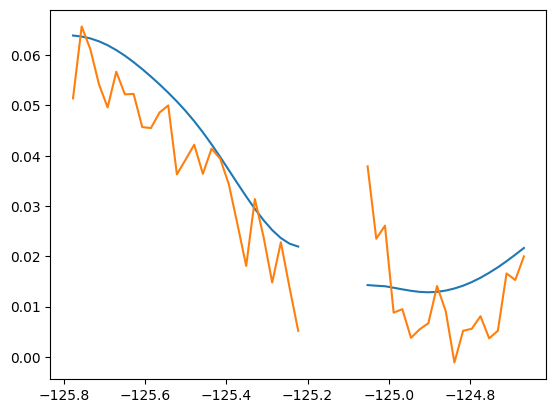

In [80]:
plt.plot(result_ssh['lon_filtered'][250],result_ssh['data_filtered'][51,250,:])
plt.plot(result_ssh['lon_filtered'][250],swot_sla1[250,:])

In [143]:
def project_to_east_north_matrix(u_g, v_g, theta_matrix):
    """
    Project cross-track (u_g) and along-track (v_g) velocities onto eastward and northward directions.
    
    :param u_g: Cross-track velocity component
    :param v_g: Along-track velocity component
    :param theta_matrix: Matrix of angles of the SWOT track with the eastward direction in radians
    :return: (u_east, v_north) - Eastward and Northward velocity components as matrices
    """
    # Convert angle to radians if needed
    if np.any(theta_matrix > 2 * np.pi):
        theta_matrix = np.deg2rad(theta_matrix)
        
    u_east = u_g * np.cos(theta_matrix) - v_g * np.sin(theta_matrix)
    v_north = u_g * np.sin(theta_matrix) + v_g * np.cos(theta_matrix)
    
    return u_east, v_north

def compute_geostrophic_velocities_and_eke_through_time(time, lat, lon, ssha, ssha_noiseless,passe):
    """
    Compute geostrophic velocities and EKE from SSH data for both noisy and noiseless SSH, and project velocities onto eastward and northward directions.
    
    Parameters:
    lat (numpy.ndarray): Latitude values, 2D array (num_lines, num_pixels).
    lon (numpy.ndarray): Longitude values, 2D array (num_lines, num_pixels).
    ssha (numpy.ndarray): Noisy sea surface height values, 3D array (time, num_lines, num_pixels).
    ssha_noiseless (numpy.ndarray): Noiseless sea surface height values, 3D array (time, num_lines, num_pixels).
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g', 'v_g', 'u_g_noiseless', 'v_g_noiseless', 'eke', and 'eke_noiseless'.
    """
    # Ensure input arrays have the correct dimensions
    assert lat.shape == lon.shape, "Latitude and longitude arrays must have the same shape."
    assert ssha.shape == ssha_noiseless.shape, "SSHA and SSHA_noiseless arrays must have the same shape."
    assert ssha.shape[1:] == lat.shape, "SSH spatial dimensions must match latitude and longitude dimensions."

    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters

    # Initialize arrays for gradients, velocities, and EKE
    grad_ssh_x = np.full_like(ssha, np.nan)
    grad_ssh_y = np.full_like(ssha, np.nan)
    u_g = np.full_like(ssha, np.nan)
    v_g = np.full_like(ssha, np.nan)
    u_east = np.full_like(ssha, np.nan)
    v_north = np.full_like(ssha, np.nan)
    eke = np.full_like(ssha, np.nan)

    grad_ssh_x_noiseless = np.full_like(ssha_noiseless, np.nan)
    grad_ssh_y_noiseless = np.full_like(ssha_noiseless, np.nan)
    u_g_noiseless = np.full_like(ssha_noiseless, np.nan)
    v_g_noiseless = np.full_like(ssha_noiseless, np.nan)
    u_east_noiseless = np.full_like(ssha_noiseless, np.nan)
    v_north_noiseless = np.full_like(ssha_noiseless, np.nan)
    eke_noiseless = np.full_like(ssha_noiseless, np.nan)

    # Calculate heading angle based on latitude and longitude differences using np.gradient
    east, north = lonlat2km(lon[0,0], lat[0,0], lon, lat)
    delta_lon, delta_lat = np.gradient(east), np.gradient(north)
    import math

    def radians_to_degrees(radians):
        return radians * (180 / math.pi)
    rad = np.arctan2(delta_lat[0], delta_lon[0])
    if passe=='pass_26':
        heading = np.radians((radians_to_degrees(rad)+90))#+90)[0]
        # heading=180+90-theta
        print(heading)
    else:
        heading = np.radians((radians_to_degrees(rad)-90))#+90)[0]
        # heading=180+90-theta
        print(heading)

    # Loop through each time step
    for t in range(ssha.shape[0]):
        # Create xarray.Dataset for the current time step
        ds = xr.Dataset(
            {
                'SSHA': (['num_lines', 'num_pixels'], ssha[t]),
                'SSHA_noiseless': (['num_lines', 'num_pixels'], ssha_noiseless[t])
            },
            coords={
                'latitude': (['num_lines', 'num_pixels'], lat),
                'longitude': (['num_lines', 'num_pixels'], lon)
            }
        )

        # Calculate the Coriolis parameter
        ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))

        # Calculate spatial deltas in meters for longitude and latitude
        # Longitude
        longitude_diff = np.diff(ds.longitude, axis=1)
        longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
        longitude_diff[longitude_diff < -180] += 360
        longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
        dx = xr.DataArray(
            (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Latitude
        latitude_diff = np.diff(ds.latitude, axis=0)
        latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
        dy = xr.DataArray(
            (earth_radius * np.pi / 180) * latitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Compute gradients of SSH for both noisy and noiseless SSH
        ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSHA, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)
        ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSHA, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)

        ds['grad_ssh_x_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        ds['grad_ssh_y_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        
        grad_ssh_x[t] = ds['grad_ssh_x']
        grad_ssh_y[t] = ds['grad_ssh_y']
        
        grad_ssh_x_noiseless[t] = ds['grad_ssh_x_noiseless']
        grad_ssh_y_noiseless[t] = ds['grad_ssh_y_noiseless']

        # Calculate geostrophic velocities for both noisy and noiseless SSH
        u_g[t] = -g / ds['f'] * ds['grad_ssh_y']
        v_g[t] = g / ds['f'] * ds['grad_ssh_x']

        u_g_noiseless[t] = -g / ds['f'] * ds['grad_ssh_y_noiseless']
        v_g_noiseless[t] = g / ds['f'] * ds['grad_ssh_x_noiseless']

        # Project geostrophic velocities onto eastward and northward directions
        u_east[t], v_north[t] = project_to_east_north_matrix(u_g[t], v_g[t], heading)
        u_east_noiseless[t], v_north_noiseless[t] = project_to_east_north_matrix(u_g_noiseless[t], v_g_noiseless[t], heading)

    # Calculate mean geostrophic velocities
    u_g_mean = np.nanmean(u_g, axis=0)
    v_g_mean = np.nanmean(v_g, axis=0)
    u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
    v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)

    # Compute deviations from the mean
    u_g_prime = u_g - u_g_mean
    v_g_prime = v_g - v_g_mean
    u_g_noiseless_prime = u_g_noiseless - u_g_noiseless_mean
    v_g_noiseless_prime = v_g_noiseless - v_g_noiseless_mean

    # Calculate EKE for both noisy and noiseless SSH
    eke = 0.5 * (u_g_prime**2 + v_g_prime**2)
    eke_noiseless = 0.5 * (u_g_noiseless_prime**2 + v_g_noiseless_prime**2)

    # Create the final xarray.Dataset with all time steps
    ds_final = xr.Dataset(
        {
            'SSHA': (['time', 'num_lines', 'num_pixels'], ssha),
            'SSHA_noiseless': (['time', 'num_lines', 'num_pixels'], ssha_noiseless),
            'u_g': (['time', 'num_lines', 'num_pixels'], u_g),
            'v_g': (['time', 'num_lines', 'num_pixels'], v_g),
            'u_g_noiseless': (['time', 'num_lines', 'num_pixels'], u_g_noiseless),
            'v_g_noiseless': (['time', 'num_lines', 'num_pixels'], v_g_noiseless),
            'grad_ssh_x': (['time', 'num_lines', 'num_pixels'], grad_ssh_x),
            'grad_ssh_y': (['time', 'num_lines', 'num_pixels'], grad_ssh_y),
            'grad_ssh_x_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_x_noiseless),
            'grad_ssh_y_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_y_noiseless),
            'eke': (['time', 'num_lines', 'num_pixels'], eke),
            'eke_noiseless': (['time', 'num_lines', 'num_pixels'], eke_noiseless),
            'u_east': (['time', 'num_lines', 'num_pixels'], u_east),
            'v_north': (['time', 'num_lines', 'num_pixels'], v_north),
            'u_east_noiseless': (['time', 'num_lines', 'num_pixels'], u_east_noiseless),
            'v_north_noiseless': (['time', 'num_lines', 'num_pixels'], v_north_noiseless)
        },
        coords={
            'latitude': (['num_lines', 'num_pixels'], lat),
            'longitude': (['num_lines', 'num_pixels'], lon),
            'time': (['time'], time)
        }
    )

    return ds_final

In [127]:
cutoff_1_50['data_filtered'].shape

(96, 407, 69)

In [128]:
time.shape

(97,)

In [145]:
time = nc_swot_13_filt.time.values
time2 = nc_swot_26_filt.time.values

In [144]:
ds_13 = compute_geostrophic_velocities_and_eke_through_time(time, lat1.values, lon1.values, cutoff_1_50['data_filtered'], cutoff_1_50['data_filtered'],'pass_13')

[[-0.18955229 -0.1897377  -0.18993356 ... -0.20166997 -0.20186636
  -0.20206275]
 [-0.1896166  -0.18978928 -0.18998514 ... -0.20173945 -0.20193583
  -0.20211464]
 [-0.1897093  -0.18991038 -0.19008307 ... -0.2018608  -0.20202846
  -0.20220727]
 ...
 [-0.23684131 -0.23708933 -0.23736022 ... -0.25363277 -0.25386567
  -0.25413723]
 [-0.23699142 -0.23723296 -0.23750386 ... -0.25379926 -0.25402522
  -0.25429678]
 [-0.23708933 -0.23733088 -0.23757242 ... -0.25388152 -0.25410944
  -0.25436515]]


/tmp/ipykernel_18804/552506840.py:139: RuntimeWarning: Mean of empty slice
  u_g_mean = np.nanmean(u_g, axis=0)
/tmp/ipykernel_18804/552506840.py:140: RuntimeWarning: Mean of empty slice
  v_g_mean = np.nanmean(v_g, axis=0)
/tmp/ipykernel_18804/552506840.py:141: RuntimeWarning: Mean of empty slice
  u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
/tmp/ipykernel_18804/552506840.py:142: RuntimeWarning: Mean of empty slice
  v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)


In [146]:
ds_26 = compute_geostrophic_velocities_and_eke_through_time(time2, lat2.values, lon2.values, cutoff_1_50_1['data_filtered'], cutoff_1_50_1['data_filtered'],'pass_26')

[[0.21736683 0.21758938 0.21781193 ... 0.23289079 0.233059   0.23334983]
 [0.2172917  0.21752022 0.21774276 ... 0.23279387 0.23302336 0.2332593 ]
 [0.21713831 0.21738789 0.21763149 ... 0.23264027 0.23286977 0.23309928]
 ...
 [0.17361355 0.17377212 0.17395198 ... 0.18477695 0.18495232 0.18511154]
 [0.17352362 0.17368699 0.17386686 ... 0.18468671 0.1848408  0.18502641]
 [0.17345498 0.17364443 0.17382429 ... 0.18463903 0.18477695 0.18496768]]


/tmp/ipykernel_18804/552506840.py:139: RuntimeWarning: Mean of empty slice
  u_g_mean = np.nanmean(u_g, axis=0)
/tmp/ipykernel_18804/552506840.py:140: RuntimeWarning: Mean of empty slice
  v_g_mean = np.nanmean(v_g, axis=0)
/tmp/ipykernel_18804/552506840.py:141: RuntimeWarning: Mean of empty slice
  u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
/tmp/ipykernel_18804/552506840.py:142: RuntimeWarning: Mean of empty slice
  v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)


In [147]:
# Calculate total velocity
ds_13["ut_g"] = np.sqrt(ds_13["u_g"] ** 2 + ds_13["v_g"] ** 2)
ds_13["ut_g_noiseless"] = np.sqrt(ds_13["u_east_noiseless"] ** 2 + ds_13["v_north_noiseless"] ** 2)

ds_26["ut_g"] = np.sqrt(ds_26["u_g"] ** 2 + ds_26["v_g"] ** 2)
ds_26["ut_g_noiseless"] = np.sqrt(ds_26["u_east_noiseless"] ** 2 + ds_26["v_north_noiseless"] ** 2)


In [148]:
directory = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/swot_aviso/'
ds_13.to_netcdf(directory+'FT_50_KM_SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')
ds_26.to_netcdf(directory+'FT_50_KM_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')


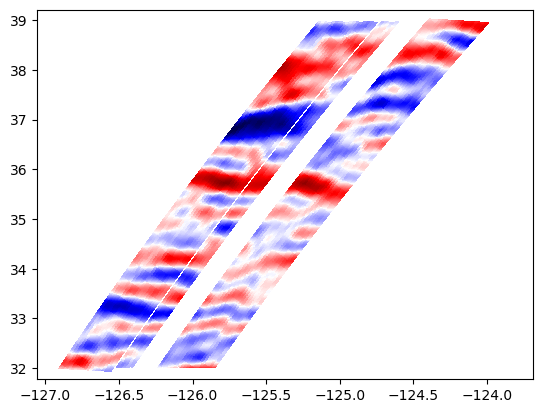

In [142]:
plt.pcolor(lon1, lat1,ds_test["u_g_noiseless"].values[80,:,:], cmap='seismic')
# plt.pcolor(lon_026[:,35:], lat_026[:,35:],da_026_filt["u_g_noiseless"].values[80,:,35:], cmap='seismic')


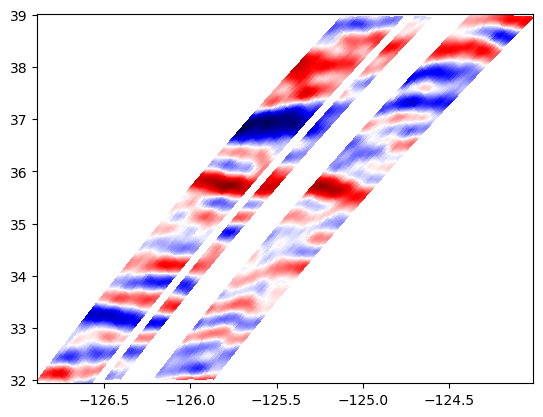

In [137]:
plt.pcolor(cutoff_1_50['lon_filtered'],cutoff_1_50['lat_filtered'],ds_test["u_g_noiseless"].values[80,:,:], cmap='seismic')
# plt.pcolor(lon_026[:,35:], lat_026[:,35:],da_026_filt["u_g_noiseless"].values[80,:,35:], cmap='seismic')


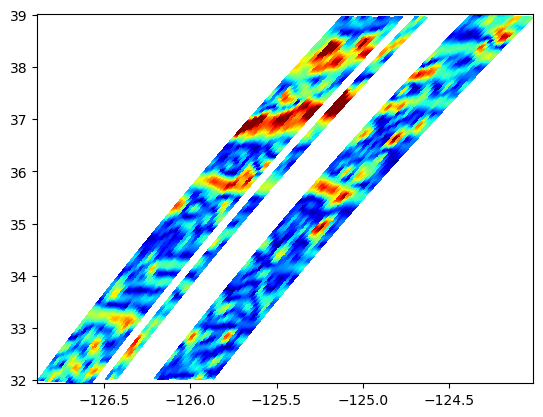

In [139]:
plt.pcolor(cutoff_1_50['lon_filtered'],cutoff_1_50['lat_filtered'],ds_test["ut_g_noiseless"].values[80,:,:],vmin = 0,vmax=0.5, cmap='jet')
